# Практическая работа №3. Свёрточные нейронные сети

**Работу выполнил:**

Мовчан Игорь, 368540

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4322 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [1]:
import numpy as np
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Блок для соединения с Google Colab

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'data/flowers'

%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive/data/flowers


In [4]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок:
dataset = ImageFolder('/content/drive/My Drive/data/flowers', transform=prepare_imgs)

In [5]:
dataset.imgs[2]

('/content/drive/My Drive/data/flowers/daisy/10172379554_b296050f82_n.jpg', 0)

In [6]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция для логирования
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [7]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [8]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [9]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3337 1000


Функция для подсчета Accuracy

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [11]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device)
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track

# Обучаем базовую модель

Запускаем обучение на 10 эпох

In [12]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 105/105 [08:33<00:00,  4.89s/it]


[training] Epoch: 0.00. Loss: 1.58. Accuracy: 27.54% 


100%|██████████| 32/32 [02:00<00:00,  3.76s/it]


[validation] Epoch: 0.00. Loss: 1.31. Accuracy: 40.80% 


100%|██████████| 105/105 [00:33<00:00,  3.14it/s]


[training] Epoch: 1.00. Loss: 1.43. Accuracy: 35.48% 


100%|██████████| 32/32 [00:07<00:00,  4.14it/s]


[validation] Epoch: 1.00. Loss: 1.23. Accuracy: 45.60% 


100%|██████████| 105/105 [00:34<00:00,  3.08it/s]


[training] Epoch: 2.00. Loss: 1.33. Accuracy: 40.99% 


100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


[validation] Epoch: 2.00. Loss: 1.20. Accuracy: 48.60% 


100%|██████████| 105/105 [00:34<00:00,  3.04it/s]


[training] Epoch: 3.00. Loss: 1.25. Accuracy: 45.47% 


100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


[validation] Epoch: 3.00. Loss: 1.15. Accuracy: 51.47% 


100%|██████████| 105/105 [00:34<00:00,  3.07it/s]


[training] Epoch: 4.00. Loss: 1.17. Accuracy: 49.82% 


100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


[validation] Epoch: 4.00. Loss: 1.17. Accuracy: 52.94% 


100%|██████████| 105/105 [00:34<00:00,  3.06it/s]


[training] Epoch: 5.00. Loss: 1.08. Accuracy: 54.17% 


100%|██████████| 32/32 [00:07<00:00,  4.13it/s]


[validation] Epoch: 5.00. Loss: 1.19. Accuracy: 54.32% 


100%|██████████| 105/105 [00:34<00:00,  3.06it/s]


[training] Epoch: 6.00. Loss: 0.99. Accuracy: 58.35% 


100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


[validation] Epoch: 6.00. Loss: 1.30. Accuracy: 54.96% 


100%|██████████| 105/105 [00:34<00:00,  3.03it/s]


[training] Epoch: 7.00. Loss: 0.91. Accuracy: 62.26% 


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


[validation] Epoch: 7.00. Loss: 1.43. Accuracy: 55.30% 


100%|██████████| 105/105 [00:34<00:00,  3.07it/s]


[training] Epoch: 8.00. Loss: 0.84. Accuracy: 65.42% 


100%|██████████| 32/32 [00:07<00:00,  4.19it/s]


[validation] Epoch: 8.00. Loss: 1.57. Accuracy: 55.41% 


100%|██████████| 105/105 [00:34<00:00,  3.07it/s]


[training] Epoch: 9.00. Loss: 0.78. Accuracy: 68.22% 


100%|██████████| 32/32 [00:07<00:00,  4.23it/s]

[validation] Epoch: 9.00. Loss: 1.78. Accuracy: 55.55% 


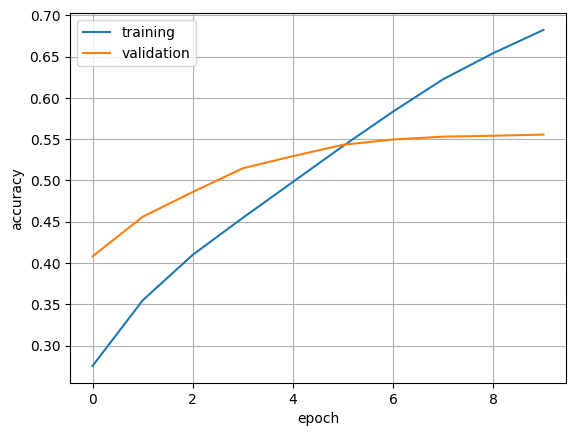

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

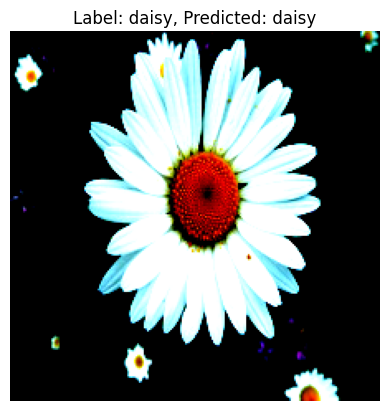

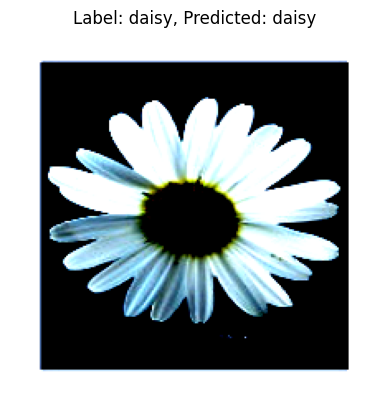

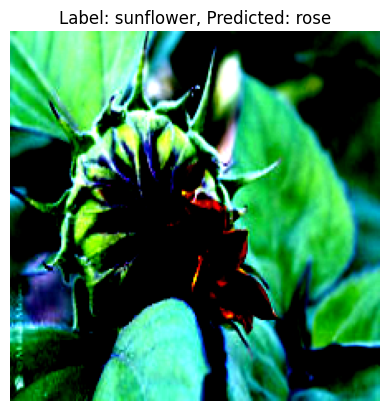

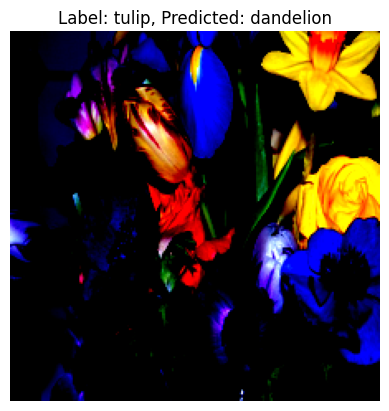

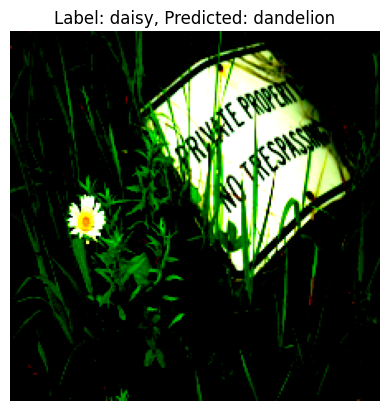

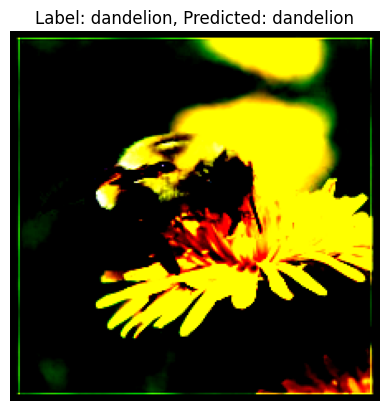

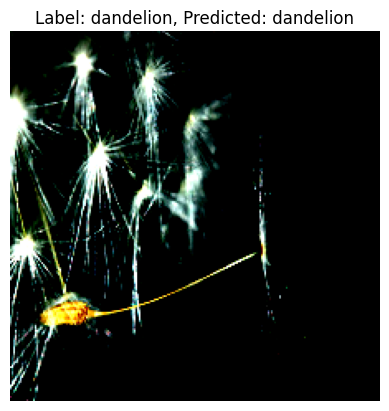

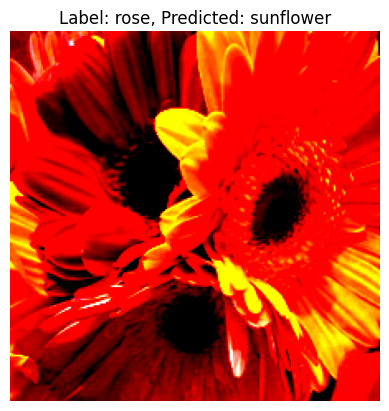

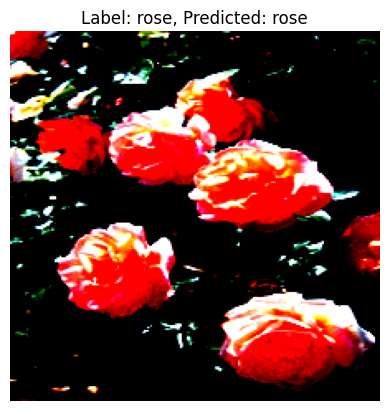

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание



В задние представлено логика выполнения с использование tensorflow/keras. Выполнять можно как с использованием tensorflow/keras, так и pytorch.

1. Необходимо обучить предобученную сверточную архитектуру для задач классификации цветов.

В выбранной Вами архитектуре также необходимо **разобраться** с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.

2. Реализовать свою архитектуру, также как в разделе "Сверточная нейросеть с нуля".

3. Сравнить три архитектуры (из раздела "Сверточная нейросеть с нуля", предобученую сверточную архитектуру и свою архитектуру (из п. 2)). Визуализировать полученный результат сравнения.





1. Обучение предобученной сверточной архитектуры для задач классификации цветов

In [16]:

# Выберите модель resnet34 (как наиболее сбалансированную)
#  из списка доступных в PyTorch моделей
# Указываем, что она модель должна быть предобучена!
model = torchvision.models.resnet34(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 138MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model) # передаём модель в функцию для "заморозки" градиента для предотвращения переобучения и сохранения способности к обобщению признаков

In [19]:
model.fc = nn.Linear(
    in_features=model.fc.in_features,  # число входов
    out_features=5  # число выходов (тк 5 классов)
) # Меняем последний слой модели для приложения к нашей задаче

In [20]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [21]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 105/105 [00:20<00:00,  5.14it/s]


[training] Epoch: 0.00. Loss: 0.98. Accuracy: 65.12% 


100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


[validation] Epoch: 0.00. Loss: 0.58. Accuracy: 81.80% 


100%|██████████| 105/105 [00:21<00:00,  4.92it/s]


[training] Epoch: 1.00. Loss: 0.75. Accuracy: 74.26% 


100%|██████████| 32/32 [00:05<00:00,  6.02it/s]


[validation] Epoch: 1.00. Loss: 0.51. Accuracy: 84.25% 


100%|██████████| 105/105 [00:24<00:00,  4.24it/s]


[training] Epoch: 2.00. Loss: 0.64. Accuracy: 78.21% 


100%|██████████| 32/32 [00:05<00:00,  5.63it/s]


[validation] Epoch: 2.00. Loss: 0.47. Accuracy: 85.50% 


100%|██████████| 105/105 [00:21<00:00,  4.95it/s]


[training] Epoch: 3.00. Loss: 0.58. Accuracy: 80.16% 


100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


[validation] Epoch: 3.00. Loss: 0.45. Accuracy: 86.10% 


100%|██████████| 105/105 [00:24<00:00,  4.32it/s]


[training] Epoch: 4.00. Loss: 0.53. Accuracy: 81.91% 


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


[validation] Epoch: 4.00. Loss: 0.43. Accuracy: 86.40% 


100%|██████████| 105/105 [00:22<00:00,  4.68it/s]


[training] Epoch: 5.00. Loss: 0.50. Accuracy: 83.17% 


100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


[validation] Epoch: 5.00. Loss: 0.42. Accuracy: 86.78% 


100%|██████████| 105/105 [00:23<00:00,  4.46it/s]


[training] Epoch: 6.00. Loss: 0.47. Accuracy: 84.05% 


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


[validation] Epoch: 6.00. Loss: 0.41. Accuracy: 87.13% 


100%|██████████| 105/105 [00:23<00:00,  4.48it/s]


[training] Epoch: 7.00. Loss: 0.45. Accuracy: 84.80% 


100%|██████████| 32/32 [00:07<00:00,  4.34it/s]


[validation] Epoch: 7.00. Loss: 0.40. Accuracy: 87.31% 


100%|██████████| 105/105 [00:26<00:00,  3.93it/s]


[training] Epoch: 8.00. Loss: 0.43. Accuracy: 85.43% 


100%|██████████| 32/32 [00:06<00:00,  5.30it/s]


[validation] Epoch: 8.00. Loss: 0.40. Accuracy: 87.37% 


100%|██████████| 105/105 [00:20<00:00,  5.05it/s]


[training] Epoch: 9.00. Loss: 0.42. Accuracy: 85.90% 


100%|██████████| 32/32 [00:06<00:00,  4.78it/s]

[validation] Epoch: 9.00. Loss: 0.39. Accuracy: 87.64% 


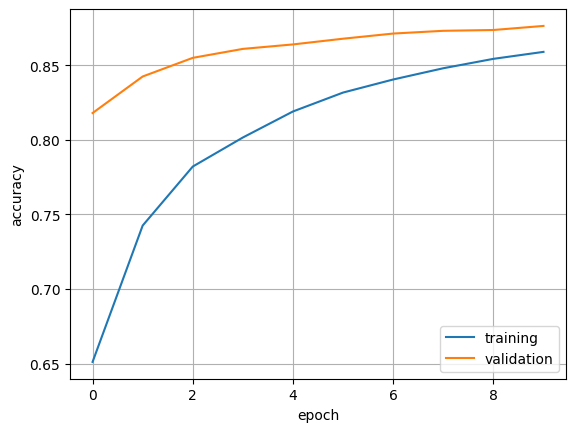

In [22]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

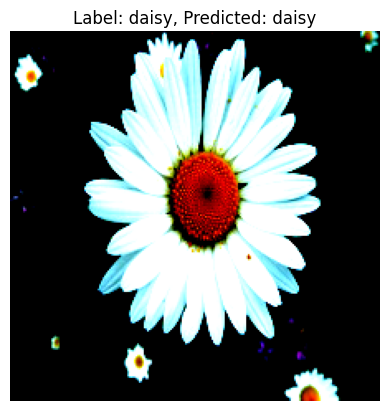

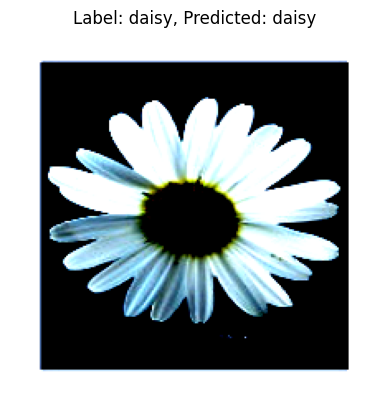

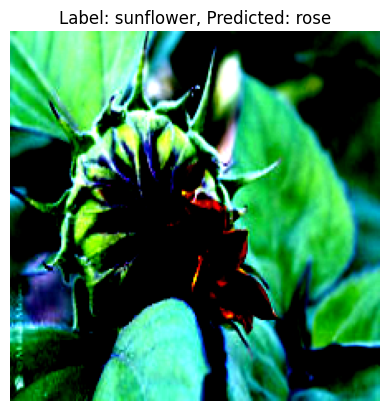

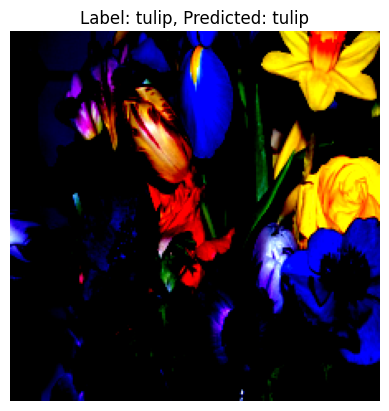

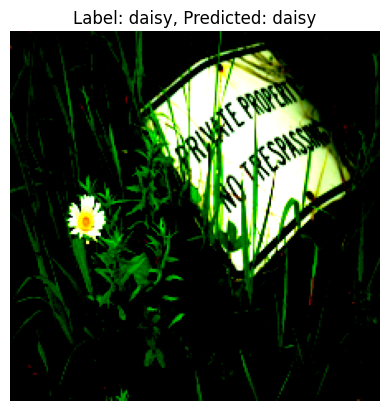

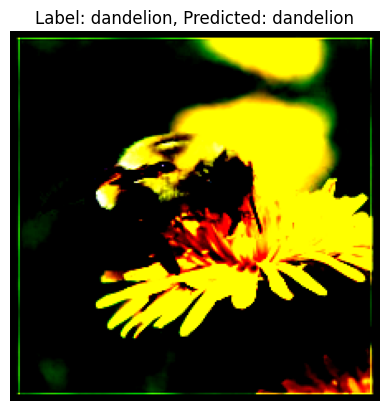

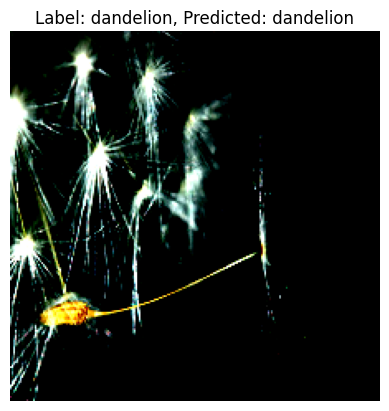

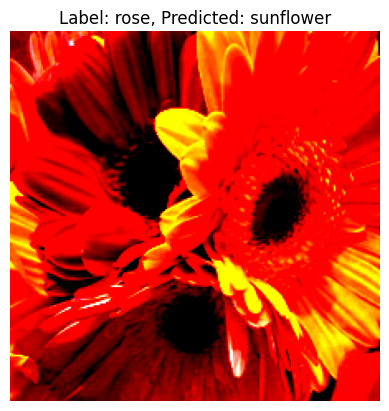

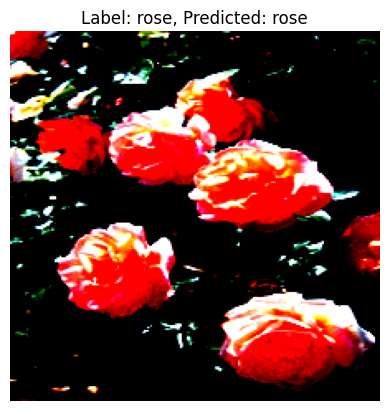

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

Также сохраним веса модели.

In [25]:
weights_fname = '/content/drive/My Drive/data/flower_model_koefs.pth'
torch.save(model.state_dict(), weights_fname)

2. Своя архитектура

In [29]:
model = nn.Sequential(
    # Свёрточный блок №1
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), # непосредственно свёртка c 3 входными каналами и 32 выходными фильтрами
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2), # уменьшение размера признаков в 2 раза

    # Свёрточный блок №2
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # Свёрточный блок №3
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    # # Преобразование вектора признаков и классификация
    nn.Flatten(),
    nn.Linear(128*28*28, 512),  # Преобразование признаков
    nn.ReLU(),
    nn.Dropout(0.25), # Бьёмся с переобучением
    nn.Linear(512, 5)  # 5 classes for classification
)

model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=100352, out_features=512, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.25, inplace=False)
  (13): Linear(in_features=512, out_features=5, bias=True)
)

In [30]:
batch_size = 32
optimizer = torch.optim.Adam(params = model.parameters())
lr = 0.001 # шаг обучения

Обучим, используя уже написанное `trainval`:

In [31]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 105/105 [00:19<00:00,  5.30it/s]


[training] Epoch: 0.00. Loss: 1.37. Accuracy: 46.21% 


100%|██████████| 32/32 [00:05<00:00,  5.95it/s]


[validation] Epoch: 0.00. Loss: 1.21. Accuracy: 47.90% 


100%|██████████| 105/105 [00:22<00:00,  4.70it/s]


[training] Epoch: 1.00. Loss: 1.22. Accuracy: 51.20% 


100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


[validation] Epoch: 1.00. Loss: 1.12. Accuracy: 53.60% 


100%|██████████| 105/105 [00:21<00:00,  4.92it/s]


[training] Epoch: 2.00. Loss: 1.14. Accuracy: 54.98% 


100%|██████████| 32/32 [00:05<00:00,  6.09it/s]


[validation] Epoch: 2.00. Loss: 1.08. Accuracy: 55.23% 


100%|██████████| 105/105 [00:20<00:00,  5.11it/s]


[training] Epoch: 3.00. Loss: 1.06. Accuracy: 58.38% 


100%|██████████| 32/32 [00:06<00:00,  4.75it/s]


[validation] Epoch: 3.00. Loss: 1.04. Accuracy: 57.65% 


100%|██████████| 105/105 [00:25<00:00,  4.07it/s]


[training] Epoch: 4.00. Loss: 0.98. Accuracy: 62.02% 


100%|██████████| 32/32 [00:05<00:00,  5.88it/s]


[validation] Epoch: 4.00. Loss: 1.03. Accuracy: 58.78% 


100%|██████████| 105/105 [00:20<00:00,  5.20it/s]


[training] Epoch: 5.00. Loss: 0.89. Accuracy: 65.64% 


100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


[validation] Epoch: 5.00. Loss: 1.05. Accuracy: 59.47% 


100%|██████████| 105/105 [00:20<00:00,  5.01it/s]


[training] Epoch: 6.00. Loss: 0.80. Accuracy: 69.24% 


100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


[validation] Epoch: 6.00. Loss: 1.11. Accuracy: 59.47% 


100%|██████████| 105/105 [00:22<00:00,  4.76it/s]


[training] Epoch: 7.00. Loss: 0.72. Accuracy: 72.53% 


100%|██████████| 32/32 [00:07<00:00,  4.23it/s]


[validation] Epoch: 7.00. Loss: 1.18. Accuracy: 59.94% 


100%|██████████| 105/105 [00:21<00:00,  4.96it/s]


[training] Epoch: 8.00. Loss: 0.65. Accuracy: 75.18% 


100%|██████████| 32/32 [00:07<00:00,  4.28it/s]


[validation] Epoch: 8.00. Loss: 1.25. Accuracy: 60.28% 


100%|██████████| 105/105 [00:22<00:00,  4.62it/s]


[training] Epoch: 9.00. Loss: 0.59. Accuracy: 77.47% 


100%|██████████| 32/32 [00:07<00:00,  4.29it/s]

[validation] Epoch: 9.00. Loss: 1.32. Accuracy: 60.66% 


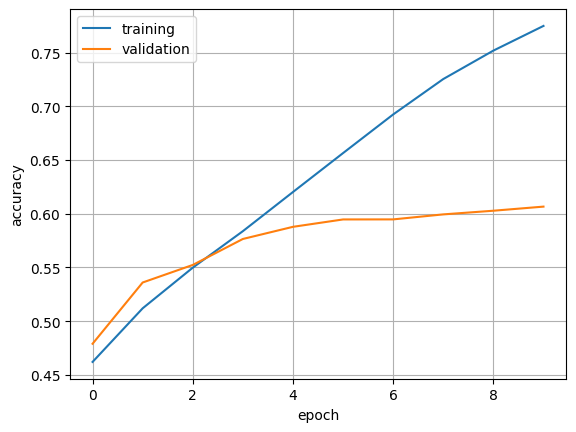

In [32]:
from matplotlib import pyplot as plt
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

3. Сравнение и вузуализация 3-х архитектур

Наилучшим образом себя показала предобученная на огромном числе данных модель с проработанной архитектурой. Что ж, видимо, в случае задач, которые уже были частично решены до этого, стоит использовать готовые модели (всё как всегда, хочешь решать часто встречающиеся практические задачи - используй готовые средства)

## Вопросы.
Архитектура предобученой resnet-34:
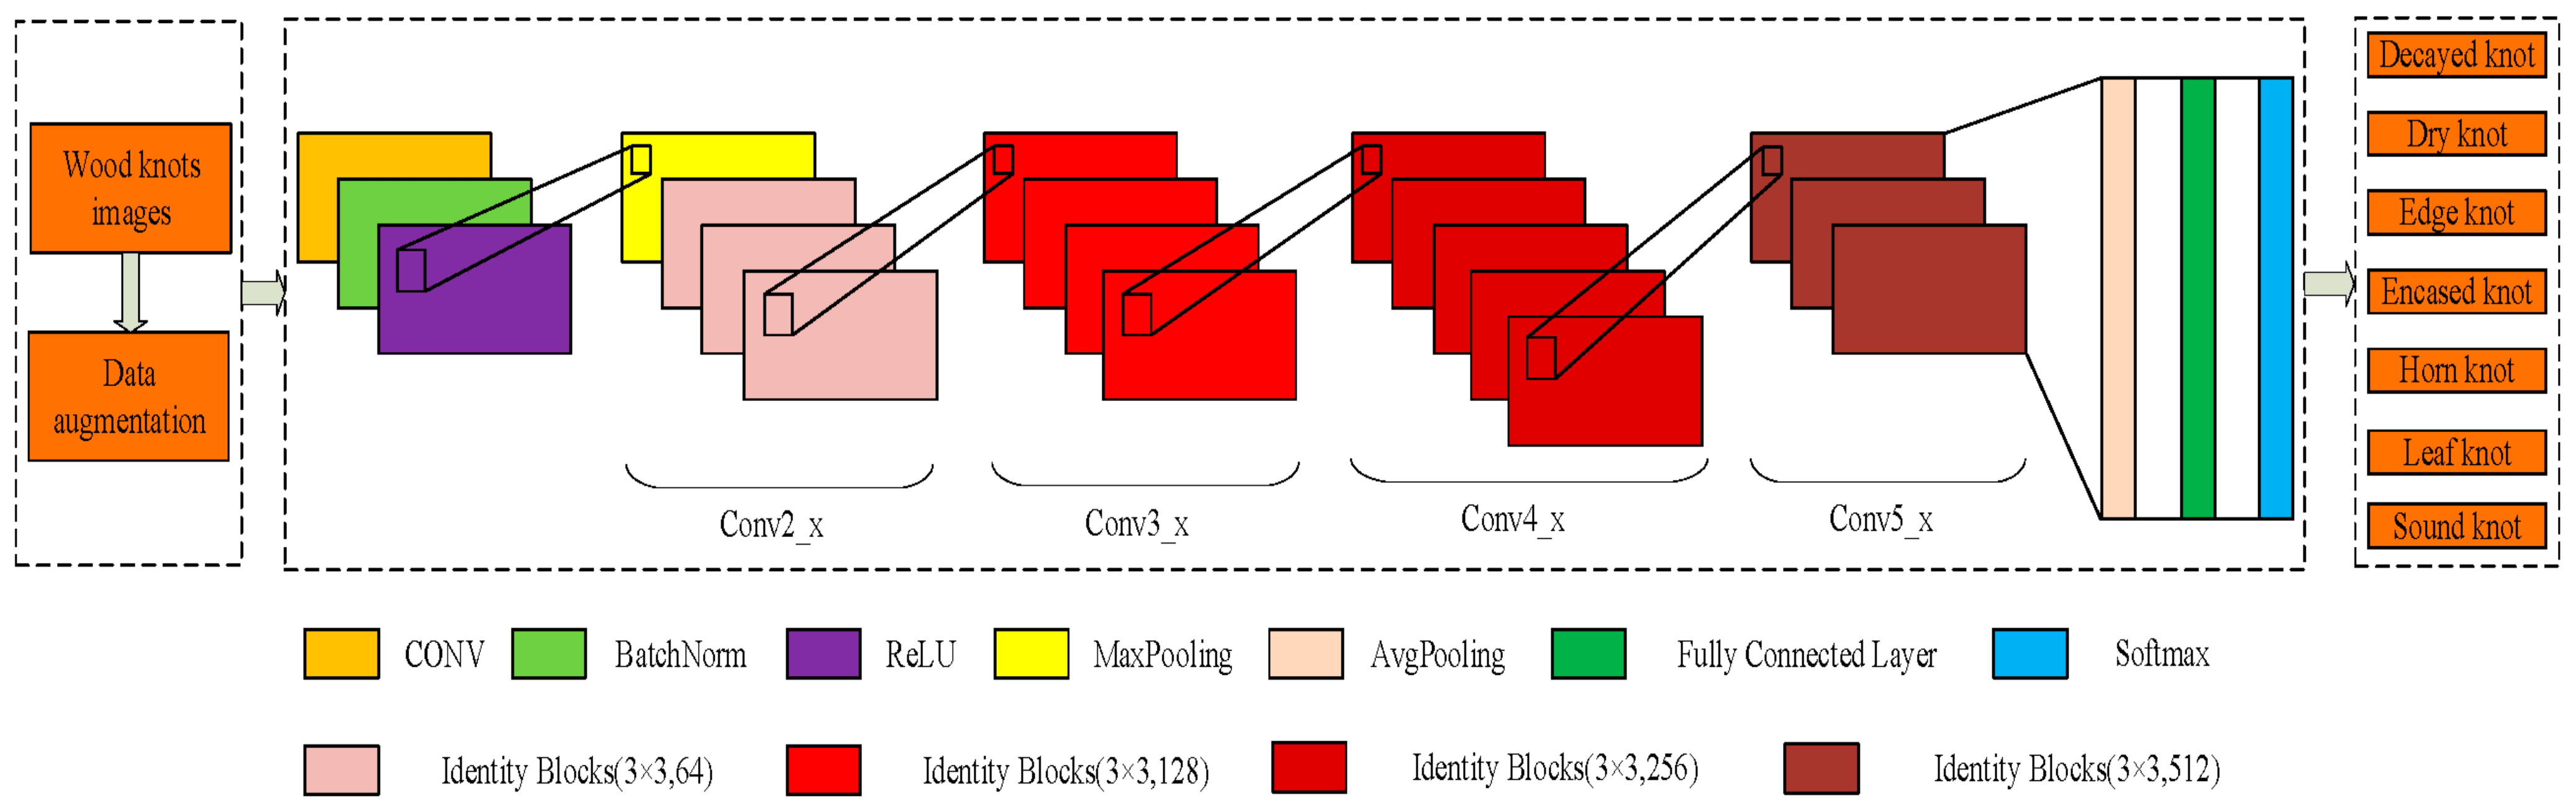

-глубокая сверточная нейронная сеть, состоящая из 34 слоёв, решает проблемы исчезающих градиентов обучения в очень глубоких сетях с помощью использования остаточных блоков (позволяют пропускать информацию, что предотвращает исчезновение градиентов).

**Полносвязная сеть:**
*   Каждая нейронная связь соединяет все нейроны текущего слоя с каждым нейроном следующего слоя.
*   Игнорирует возможные зависимости в данных.

**Сверточная сеть:** \\
*   Использует свёртку, которая сканируют локальные области
*   Использует локальные зависимости: каждый сверточный фильтр отвечает за выявление определенных шаблонов.

**Transfer learning** переносит веса, полученные при обучении модели в одной задаче, для решения другой. Такие модели, соответственно, называются предобученными нейронными сетями.

**Функция для заморозки весов** модели позволяет "заморозить" некоторые весы в процессе обучения, не позволяя им обновляться.

**Сверточный слой** применяет ядра свертки к локальным областям входных данных, чтобы выделить признаки.

**Пулинговый слой** уменьшает размер карт признаков, выбирая максимум (MaxPooling) или усредняя значения (AveragePooling) в каждой области. Это снижает вычислительную сложность и делает модель более устойчивой к изменениям в данных, например, к смещениям.